# Predicting Diatom production rate with Histogram-based Gradient Boosting Regression Tree

## Importing

In [15]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xskillscore as xs

from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.feature_selection import r_regression

from sklearn.metrics import root_mean_squared_error as rmse

import os
import lzma
import dill

import random

import salishsea_tools.viz_tools as sa_vi


## Datasets Preparation

In [16]:
# Creation of the training - testing datasets
def datasets_preparation(dataset, dataset2, name):
    
    inputs = np.stack([np.ravel(dataset['Temperature_(0m-15m)']),
        np.ravel(dataset['Temperature_(15m-100m)']), 
        np.ravel(dataset['Salinity_(0m-15m)']),
        np.ravel(dataset['Salinity_(15m-100m)']),
        np.ravel(dataset2['Summation_of_solar_radiation']),
        np.ravel(dataset2['Mean_wind_speed']),
        np.ravel(dataset2['Mean_air_temperature']),
        np.repeat(dataset.time_counter.dt.dayofyear, len(dataset.x)*len(dataset.y)),
        np.tile(np.repeat(dataset.y, len(dataset.x)), len(dataset.time_counter)),
        np.tile(dataset.x, len(dataset.time_counter)*len(dataset.y)),

        ])

    x = np.tile(dataset.x, len(dataset.time_counter)*len(dataset.y))
    y = np.tile(np.repeat(dataset.y, len(dataset.x)), len(dataset.time_counter))

    targets = np.ravel(dataset[name])
    
    indx = np.where(np.isfinite(targets) & (x>10) & ((x>100) | (y<880)))
    inputs = inputs[:,indx[0]]
    targets = targets[indx[0]]

    inputs = inputs.transpose()

    return(inputs, targets, indx)


## Datasets Preparation 2

In [17]:
# Creation of the data arrays
def datasets_preparation2(variable, name, units, dataset):

    # Obtaining the daily indexes
    temp = np.reshape(np.ravel(dataset['Temperature_(15m-100m)']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x)))
    x =  np.tile(dataset.x, len(dataset.y))
    y =  np.tile(np.repeat(dataset.y, len(dataset.x)),1)

    indx = np.where((~np.isnan(temp).any(axis=0)) & (x>10) & ((x>100) | (y<880)))

    variable_all = np.full((len(dataset.time_counter), len(dataset.y) * len(dataset.x)),np.nan)
    variable_all[:,indx[0]] = variable
    variable_all = np.reshape(variable_all,(len(dataset.time_counter),len(dataset.y),len(dataset.x)))

    # Preparation of the dataarray 
    array = xr.DataArray(variable_all,
        coords = {'time_counter': dataset.time_counter,'y': dataset.y, 'x': dataset.x},
        dims = ['time_counter','y','x'],
        attrs=dict(description= name,
        units=units))
        
    return (array)


## File Creation

In [18]:
def file_creation(path, variable, name):

    temp = variable.to_dataset(name=name)
    temp.to_netcdf(path = path + 't_p.nc', mode='w', encoding={name:{"zlib": True, "complevel": 9}})
    

## Regressor

In [19]:
def regressor (inputs, targets):

    model = TransformedTargetRegressor(regressor=make_pipeline(ColumnTransformer(
        transformers=[('drivers', StandardScaler(), [0,1,2,3,4,5,6]),('spatial', MinMaxScaler(), [8,9])],remainder='passthrough'),
        HistGradientBoostingRegressor(learning_rate=0.5, categorical_features=[7])),
        transformer=StandardScaler())
    regr = BaggingRegressor(model, n_estimators=12, n_jobs=-1).fit(inputs,targets)
    predictions = regr.predict(inputs)

    # Printing of the correlation coefficients
    r = np.round(r_regression(inputs,targets),2)
    dict = {'Temperature_(0m-15m)': r[0], 'Temperature_(15m-100m)': r[1], 'Salinity_(0m-15m)': r[2], 'Salinity_(15m-100m)': r[3],
        'Summation_of_solar_radiation': r[4], 'Mean_wind_speed': r[5], 'Mean_air_temperature': r[6], 'Day_of_the_year': r[7]}

    print('The correlation coefficients between each input and ' + name +  ' are: ' +str(dict))
    print ('The correlation coefficient during training is: ' + str(np.corrcoef(predictions,targets)[0][1]))
    print ('The rmse during training is: ' + str(rmse(predictions,targets)))

    return(regr)


## Scatter Plot

In [20]:
def scatter_plot(targets, predictions, name):

    # compute slope m and intercept b
    m, b = np.polyfit(targets, predictions, deg=1)

    fig, ax = plt.subplots(2, figsize=(5,10), layout='constrained')

    ax[0].scatter(targets,predictions, alpha = 0.2, s = 10)

    lims = [np.min([ax[0].get_xlim(), ax[0].get_ylim()]),
        np.max([ax[0].get_xlim(), ax[0].get_ylim()])]

    # plot fitted y = m*x + b
    ax[0].axline(xy1=(0, b), slope=m, color='r')

    ax[0].set_xlabel('targets')
    ax[0].set_ylabel('predictions')
    ax[0].set_xlim(lims)
    ax[0].set_ylim(lims)
    ax[0].set_aspect('equal')

    ax[0].plot(lims, lims,linestyle = '--',color = 'k')

    h = ax[1].hist2d(targets,predictions, bins=100, cmap='jet', 
        range=[lims,lims], cmin=0.1, norm='log')
    
    ax[1].plot(lims, lims,linestyle = '--',color = 'k')

    # plot fitted y = m*x + b
    ax[1].axline(xy1=(0, b), slope=m, color='r')

    ax[1].set_xlabel('targets')
    ax[1].set_ylabel('predictions')
    ax[1].set_aspect('equal')

    fig.colorbar(h[3],ax=ax[1], location='bottom')

    fig.suptitle(name)

    plt.show()

    return(m)


## Plotting (Criteria)

In [21]:
def plotting_criteria(dates, variable, year_variable, title):
    
    indx = pd.DatetimeIndex(dates)
    fig, ax = plt.subplots()

    scatter= ax.scatter(dates,variable, marker='.', c=indx.month)
    plt.xticks(rotation=70)
    ax.legend(handles=scatter.legend_elements()[0], labels=['February','March','April'])
    ax.plot(dates[(indx.month == 3) & ((indx.day == 15) | (indx.day == 16))], year_variable,color='red',marker='*')
    fig.suptitle(title + ' (15 Feb - 30 Apr)')
    
    fig.show()


## Plotting (Mean Values)

In [22]:
def plotting_mean_values(dates, mean_targets, mean_predictions, units):

    fig, _ = plt.subplots()
    
    plt.plot(dates,(mean_targets), marker = '.', linestyle = '', label = 'targets')
    plt.plot(dates,(mean_predictions), marker = '.', linestyle = '', label = 'predictions')
    plt.xlabel('Years')
    plt.xticks(rotation=70)
    plt.suptitle('Concentrations ' + units + ' (15 Feb - 30 Apr)')
    plt.legend()
    fig.show()
    

## Plotting (Maps)

In [23]:
def plotting_maps(targets, predictions, name, units):

    fig, ax = plt.subplots(2,2, figsize = (10,15), layout='tight')

    cmap = plt.get_cmap('cubehelix')
    cmap.set_bad('gray')

    targets.plot(ax=ax[0,0], cmap=cmap, vmin = targets.min(), vmax = targets.max(), cbar_kwargs={'label': name + ' ' + units})
    predictions.plot(ax=ax[0,1], cmap=cmap, vmin = targets.min(), vmax = targets.max(), cbar_kwargs={'label': name + ' ' + units})
    (targets-predictions).plot(ax=ax[1,0], cmap=cmap, cbar_kwargs={'label': name + ' ' + units})

    plt.subplots_adjust(left=0.1,
        bottom=0.1, 
        right=0.95, 
        top=0.95, 
        wspace=0.35, 
        hspace=0.35)

    sa_vi.set_aspect(ax[0,0])
    sa_vi.set_aspect(ax[0,1])
    sa_vi.set_aspect(ax[1,0])

    ax[0,0].title.set_text('Targets')
    ax[0,1].title.set_text('Predictions')
    ax[1,0].title.set_text('Targets-Predictions')
    ax[1,1].axis('off')

    fig.suptitle(name + ' '+ str(targets.time_counter.dt.date.values))

    plt.show()
    

## Evaluation

In [24]:
def evaluation (regr, ds, ds2, name):

    years = np.unique(ds.time_counter.dt.year)

    # For every year
    r_years = np.array([])
    rms_years = np.array([])
    slope_years = np.array([])

    # The data arrays 
    targets_all = []
    predictions_all = []

    for year in (years):

        dataset = ds.sel(time_counter=str(year))
        dataset2 = ds2.sel(time_counter=str(year))

        inputs, targets, indx = datasets_preparation(dataset, dataset2, name)

        predictions = regr.predict(inputs)

        # Calculating the annual time-series
        m_year = scatter_plot(targets, predictions, name + ' for '+ str(year)) 
        r_year = np.corrcoef(targets, predictions)[0][1]
        rms_year = rmse(targets, predictions)

        r_years = np.append(r_years,r_year)
        rms_years = np.append(rms_years,rms_year)
        slope_years = np.append(slope_years,m_year)

        # Daily arrays
        targets = np.reshape(targets,(len(dataset.time_counter), int(len(indx[0]) / len(dataset.time_counter))))
        predictions = np.reshape(predictions,(len(dataset.time_counter), int(len(indx[0]) / len(dataset.time_counter))))
        targets_all.append (datasets_preparation2(targets, name + ' _targets', 'mmol m-2', dataset))
        predictions_all.append(datasets_preparation2(predictions, name + ' _predictions', 'mmol m-2', dataset))   

    # Daily arrays
    targets_all = xr.concat(targets_all, dim='time_counter')
    predictions_all = xr.concat(predictions_all, dim='time_counter')
    
    return(r_years, rms_years, slope_years, targets_all, predictions_all)


## Training

In [25]:
name = 'Diatom_Production_Rate'
units = '[mmol N m-2 s-1]'

ds = xr.open_dataset('/data/ibougoudis/MOAD/files/integrated_original.nc')
ds2 = xr.open_dataset('/data/ibougoudis/MOAD/files/external_inputs.nc')

ds = ds.isel(time_counter = (np.arange(0, len(ds.time_counter),2)), 
    y=(np.arange(ds.y[0], ds.y[-1], 5)), 
    x=(np.arange(ds.x[0], ds.x[-1], 5)))

ds2 = ds2.isel(time_counter = (np.arange(0, len(ds2.time_counter),2)), 
    y=(np.arange(ds2.y[0], ds2.y[-1], 5)), 
    x=(np.arange(ds2.x[0], ds2.x[-1], 5)))

dataset = ds.sel(time_counter = slice('2007', '2020'))
dataset2 = ds2.sel(time_counter = slice('2007', '2020'))

inputs, targets, _ = datasets_preparation(dataset, dataset2, name)

regr = regressor(inputs, targets)


The correlation coefficients between each input and Diatom_Production_Rate are: {'Temperature_(0m-15m)': 0.43, 'Temperature_(15m-100m)': 0.3, 'Salinity_(0m-15m)': -0.32, 'Salinity_(15m-100m)': -0.2, 'Summation_of_solar_radiation': 0.71, 'Mean_wind_speed': -0.23, 'Mean_air_temperature': 0.27, 'Day_of_the_year': 0.53}
The correlation coefficient during training is: 0.9524479307054193
The rmse during training is: 4.6199935516096355e-07


## Other Years

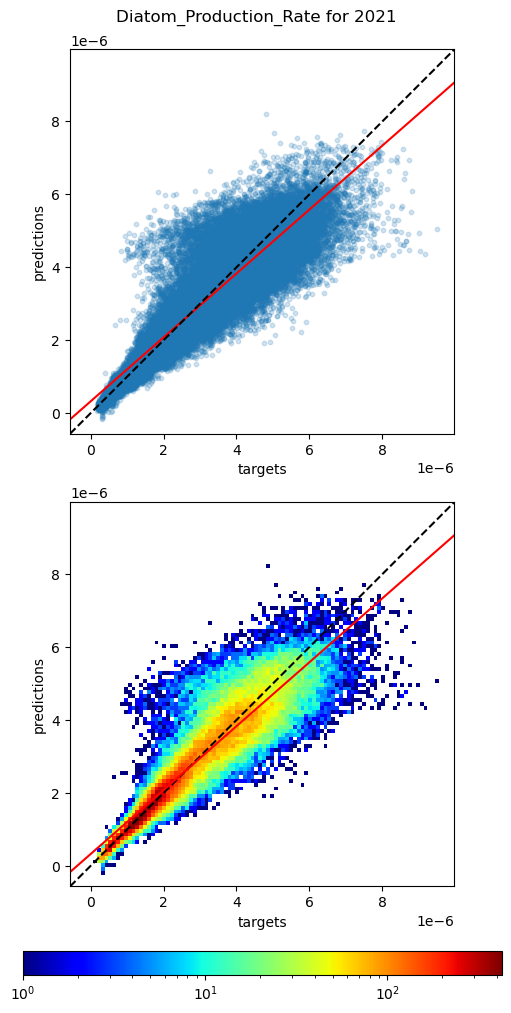

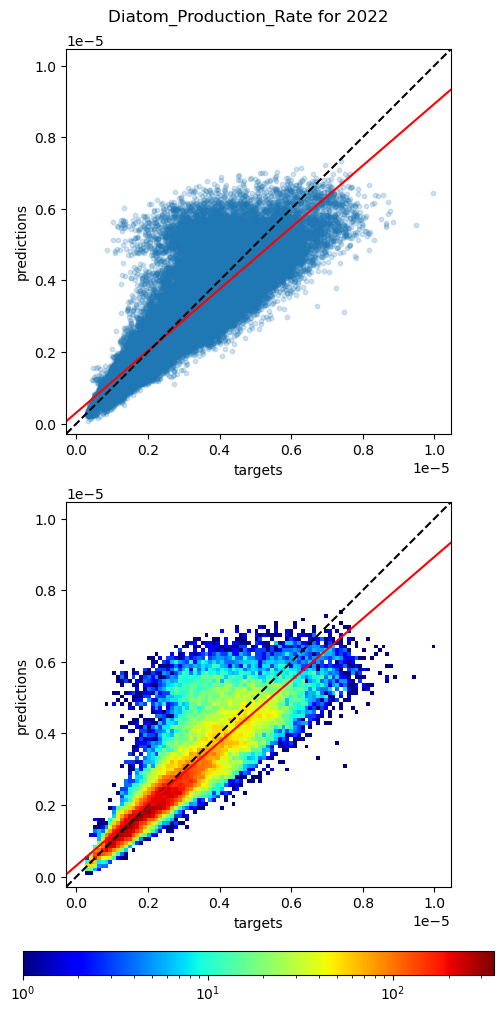

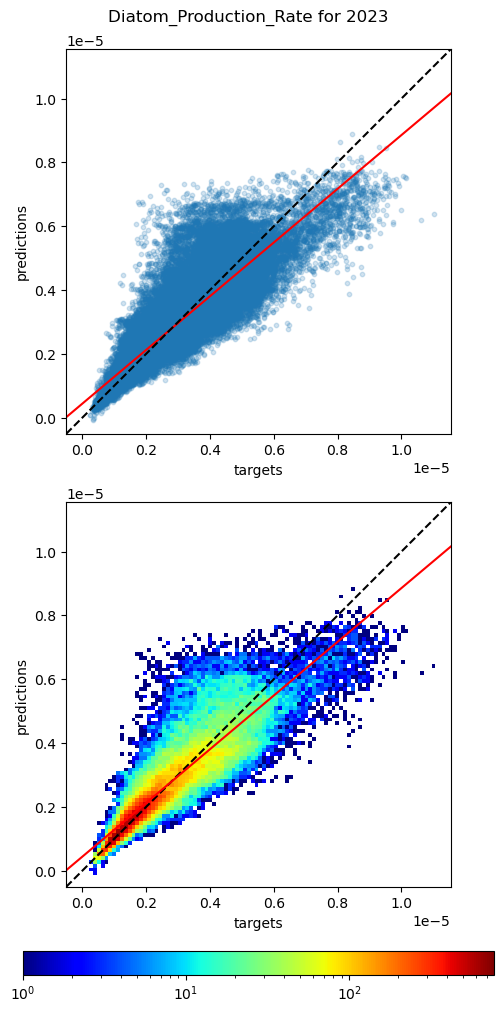

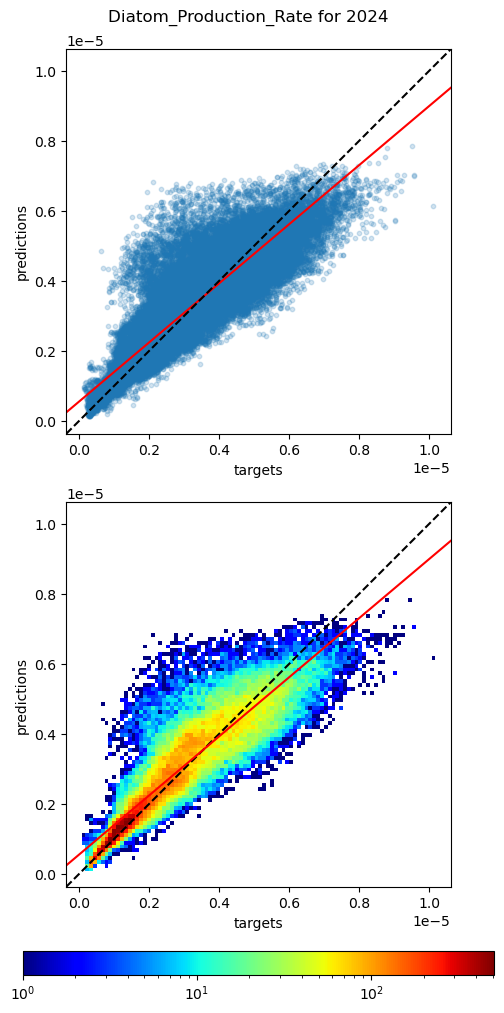

In [26]:
ds = ds.sel(time_counter = slice('2021', '2024'))
ds2 = ds2.sel(time_counter = slice('2021', '2024'))

dates = pd.DatetimeIndex(ds['time_counter'].values)

r_years, rms_years, slope_years, targets_all, predictions_all = evaluation(regr,ds,ds2, name)

r_days = xr.corr(targets_all,predictions_all, dim=['x','y'])
rms_days = xs.rmse(targets_all,predictions_all, dim=['x','y'], skipna=True)
slope_days = xs.linslope(targets_all,predictions_all, dim=['x','y'], skipna=True)

mean_targets = targets_all.mean(dim=['x','y'], skipna=True)
mean_predictions = predictions_all.mean(dim=['x','y'], skipna=True)


## Plotting (Results)

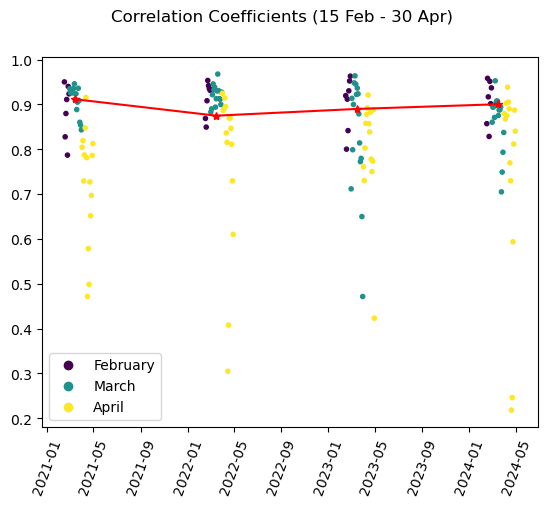

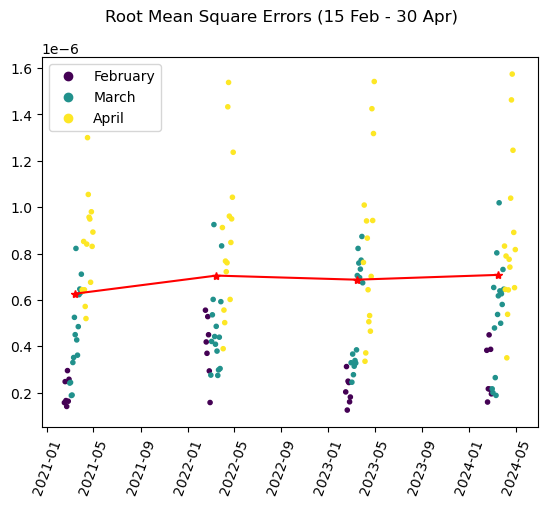

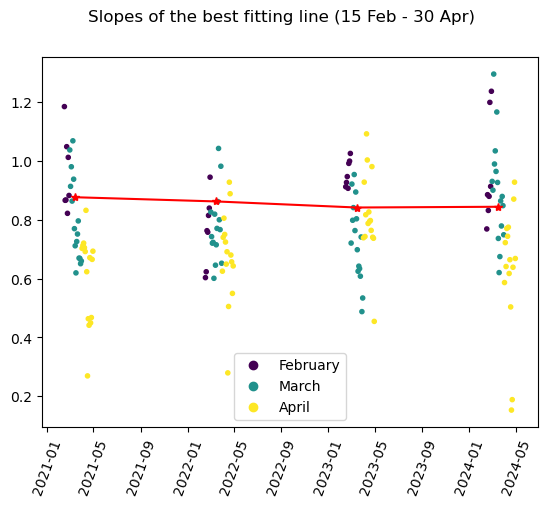

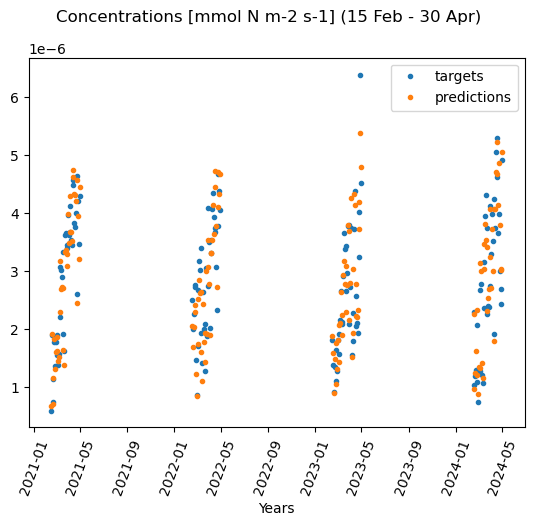

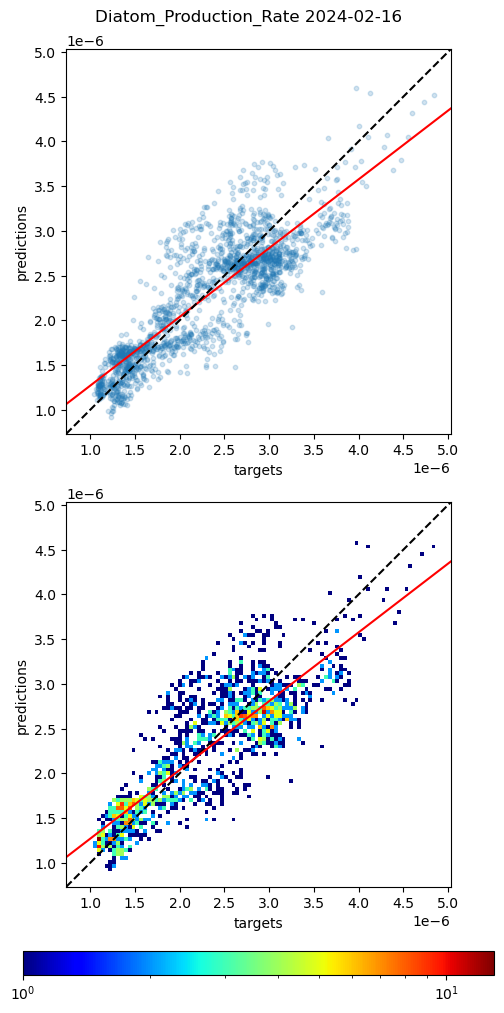

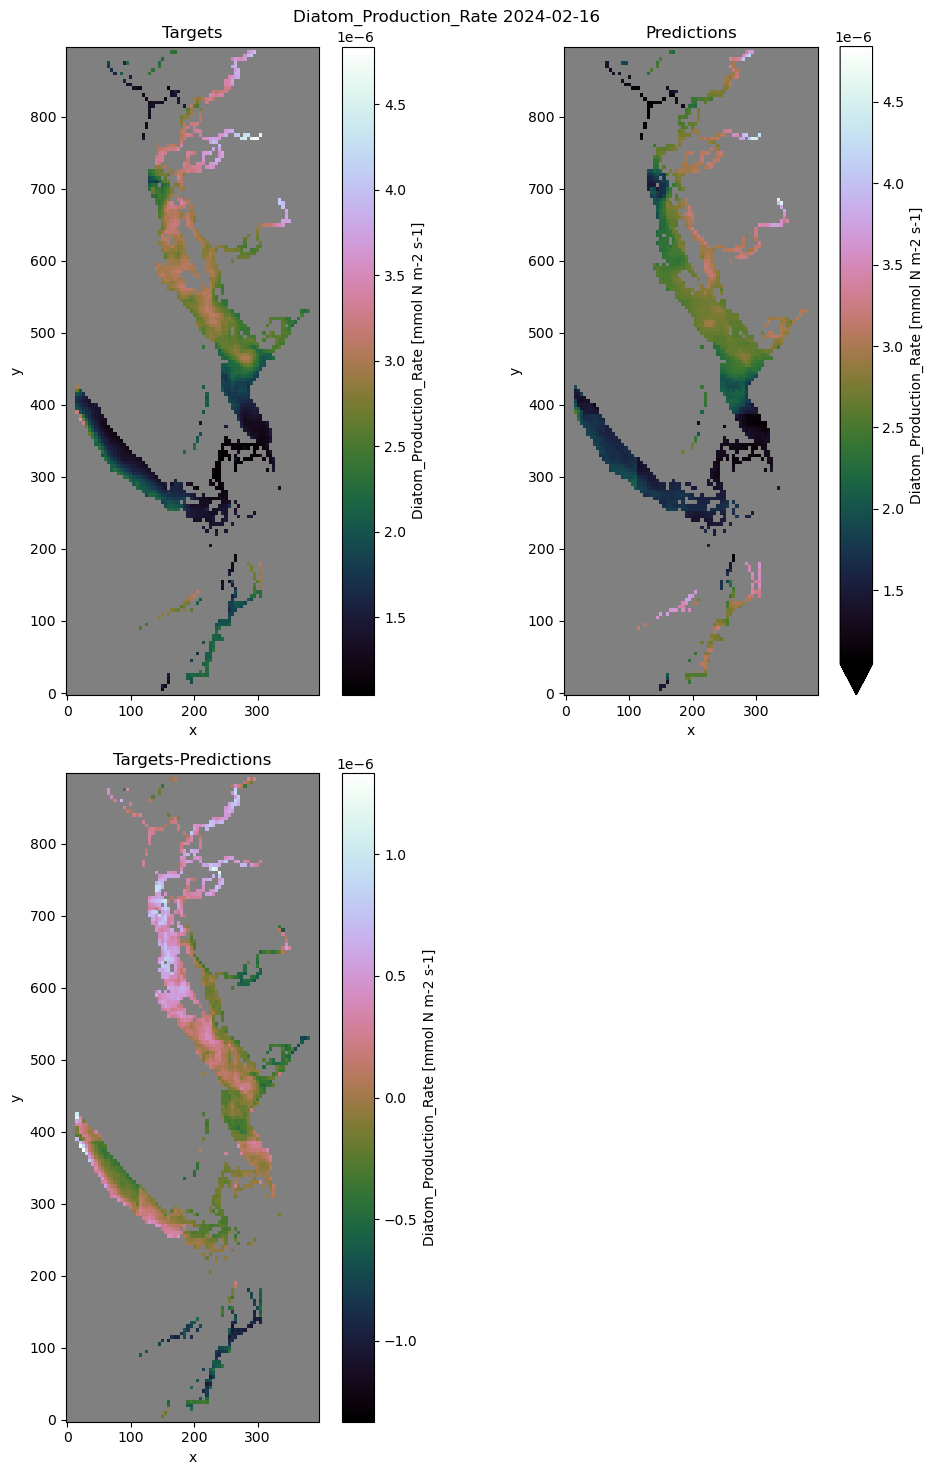

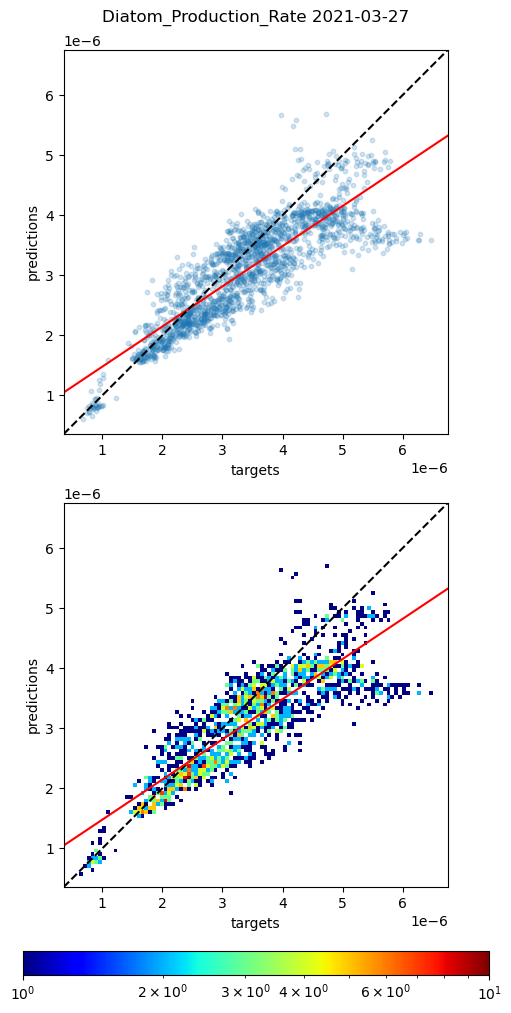

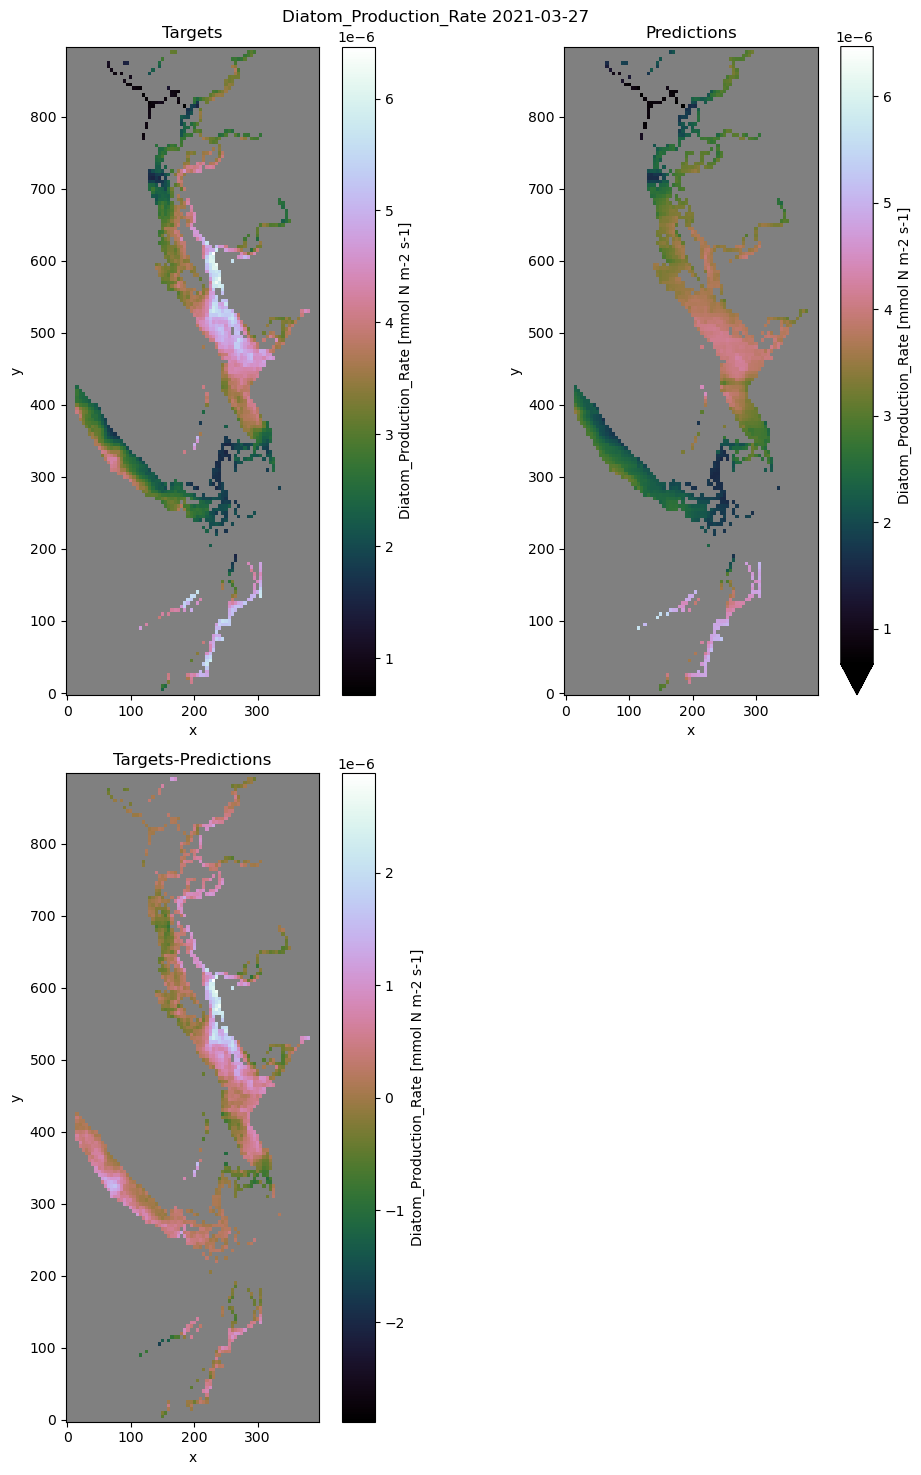

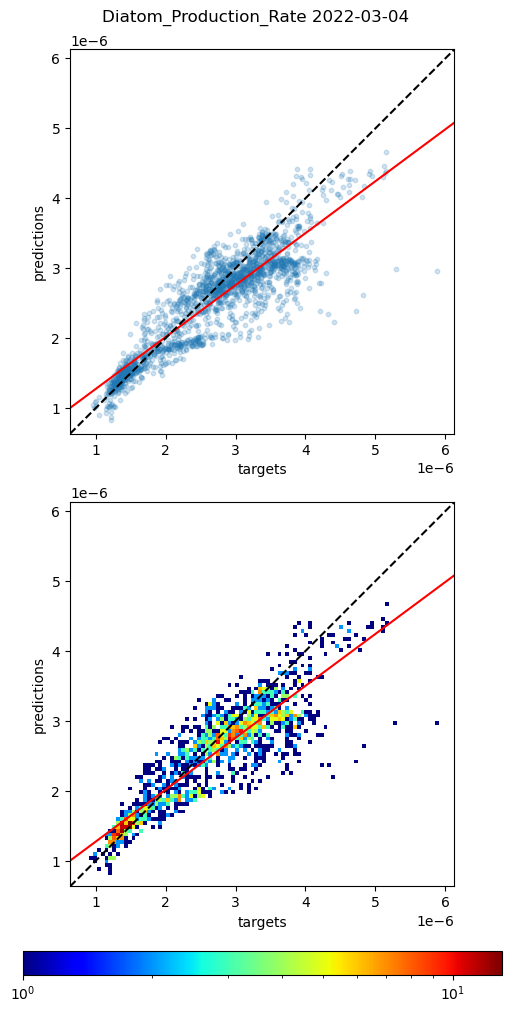

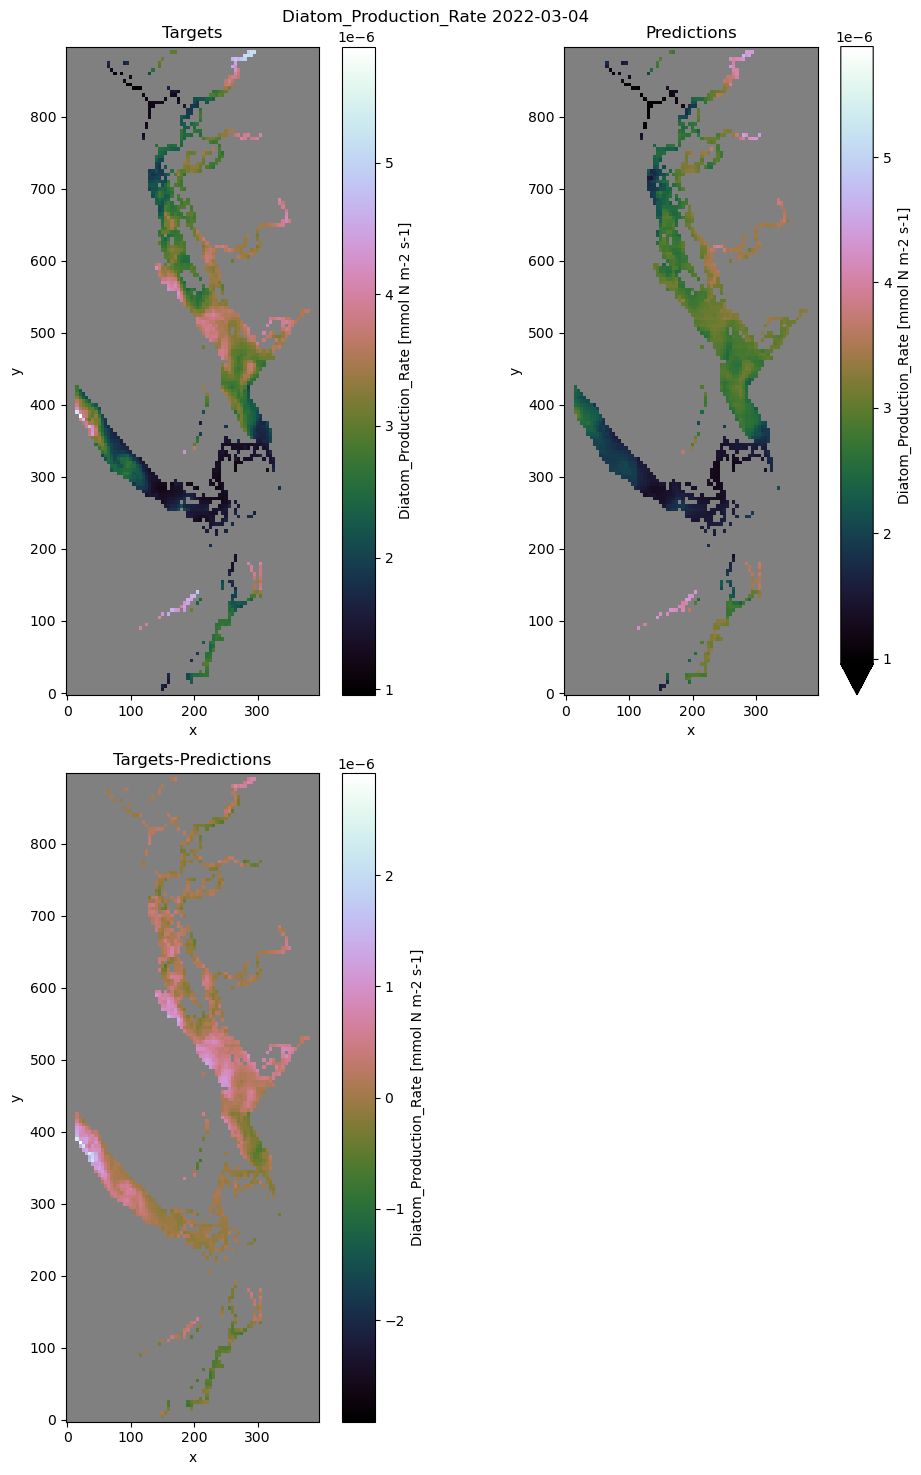

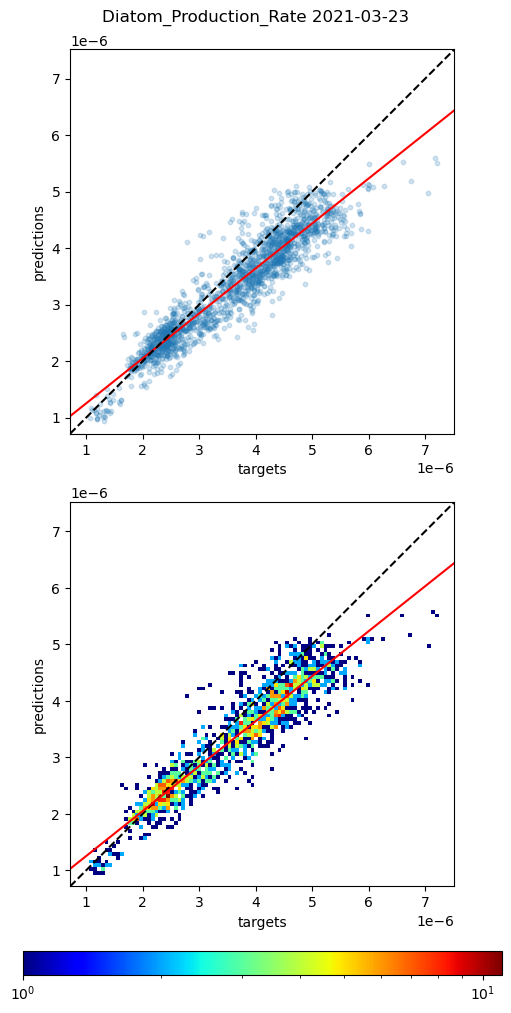

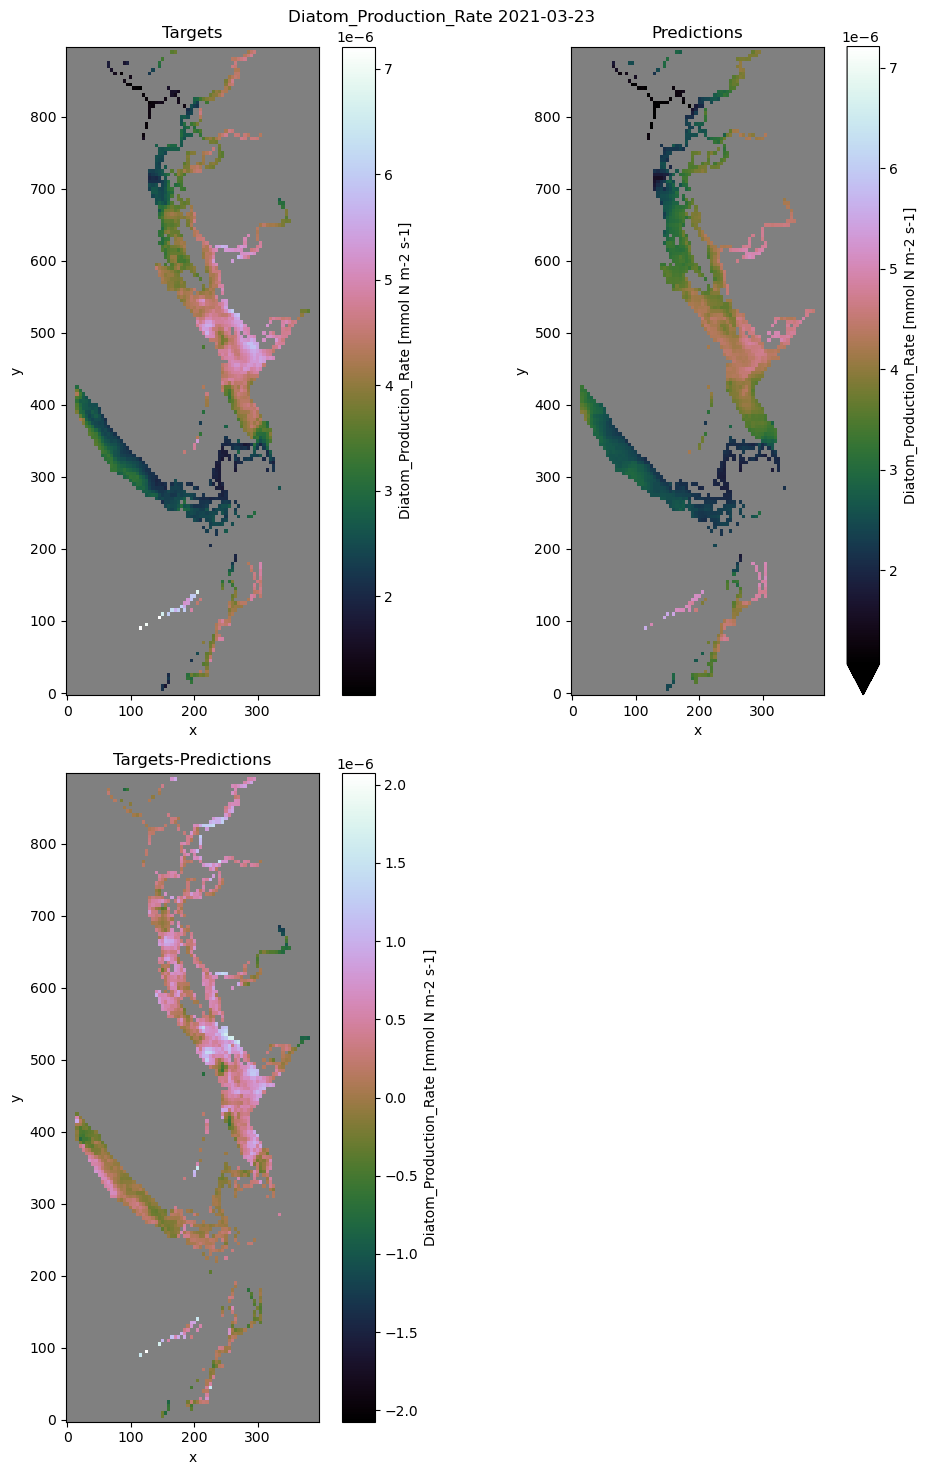

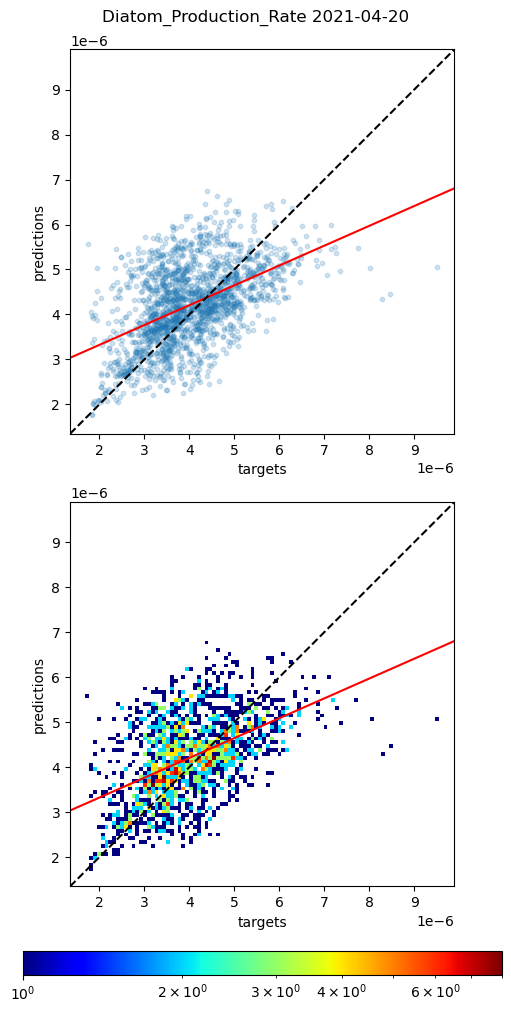

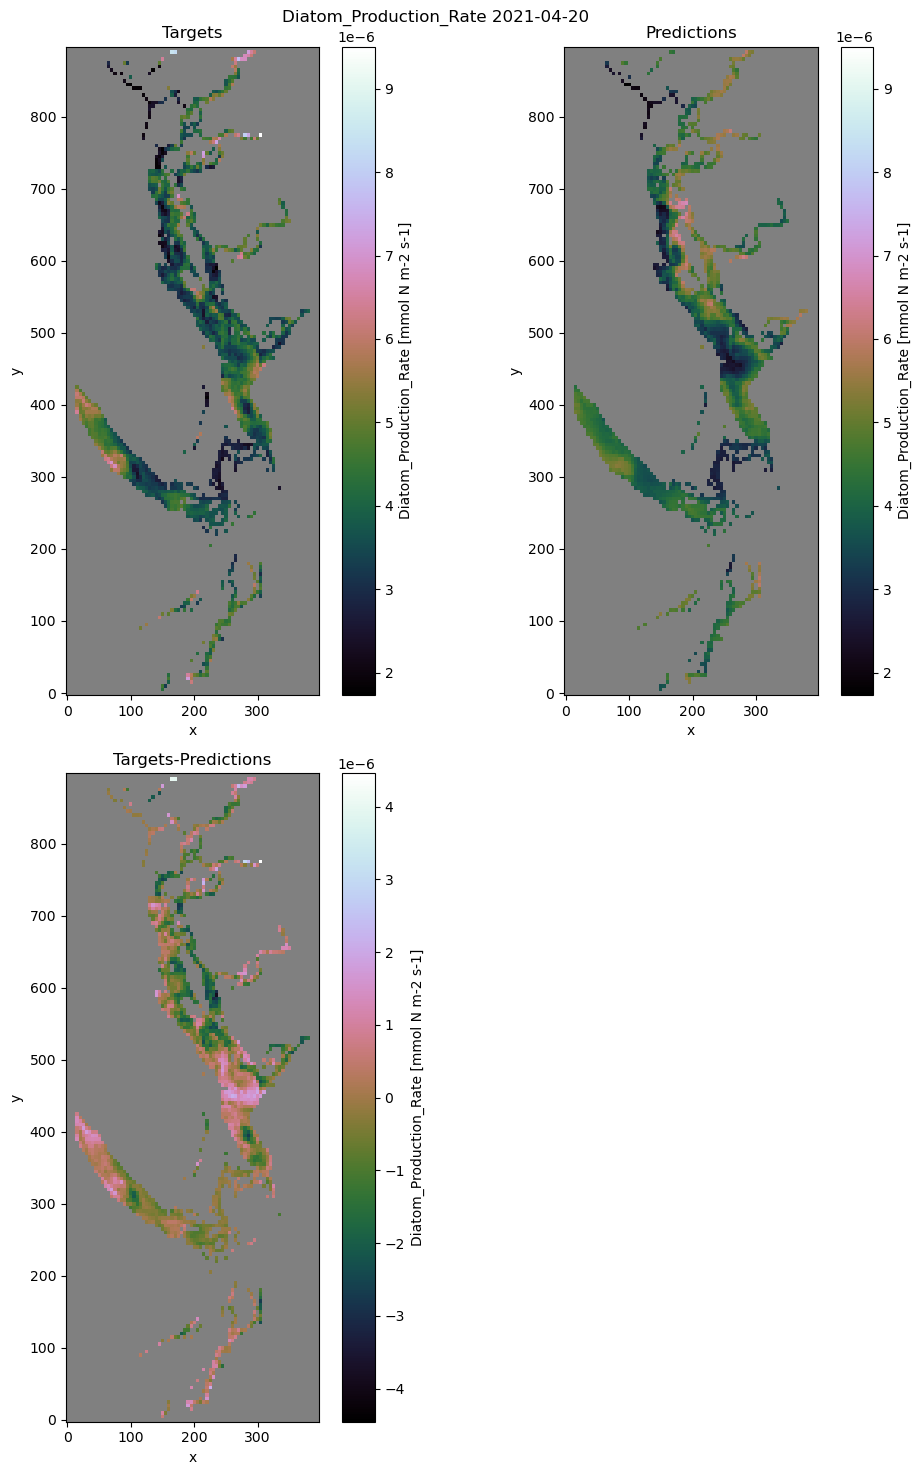

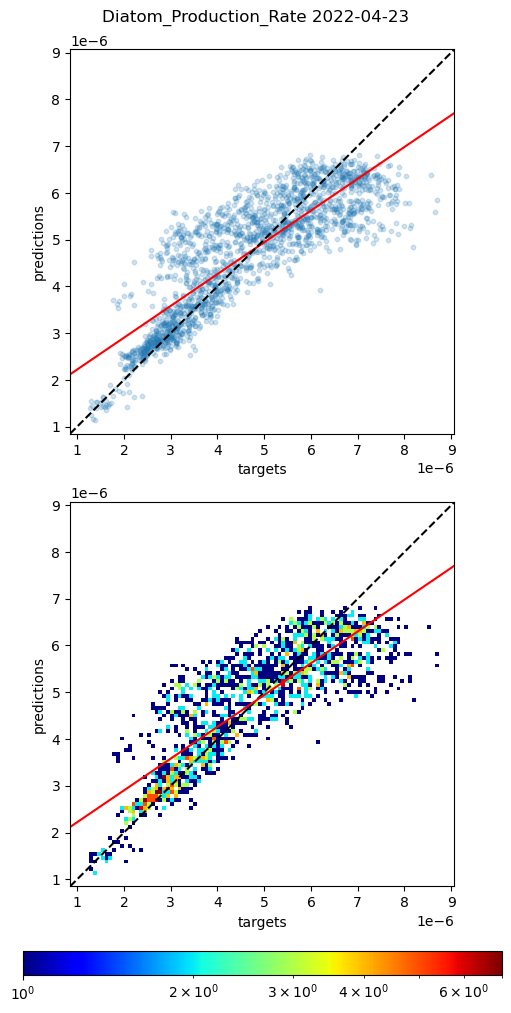

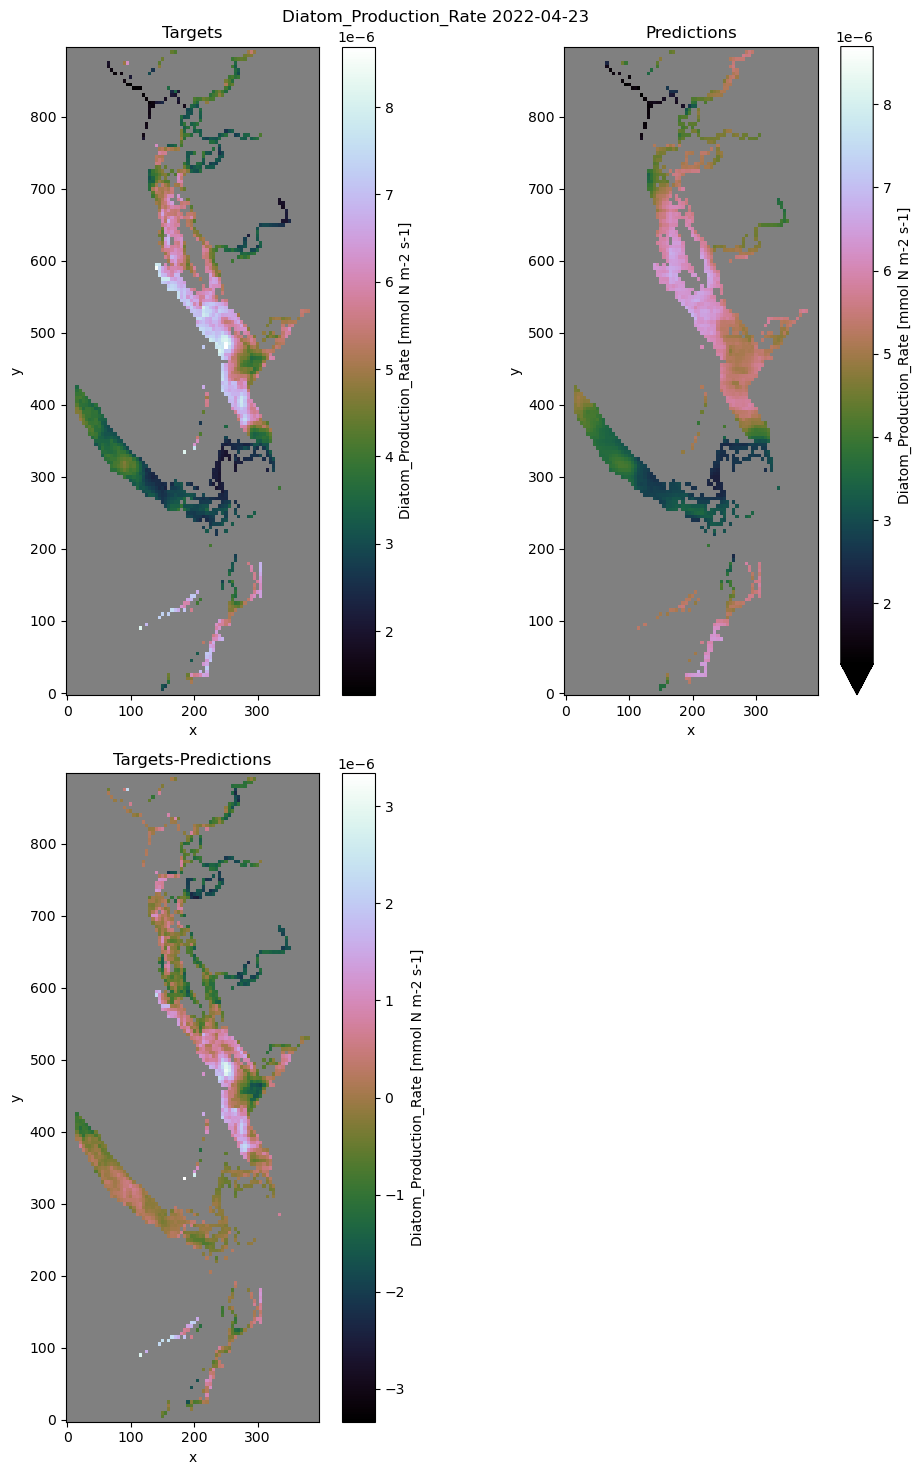

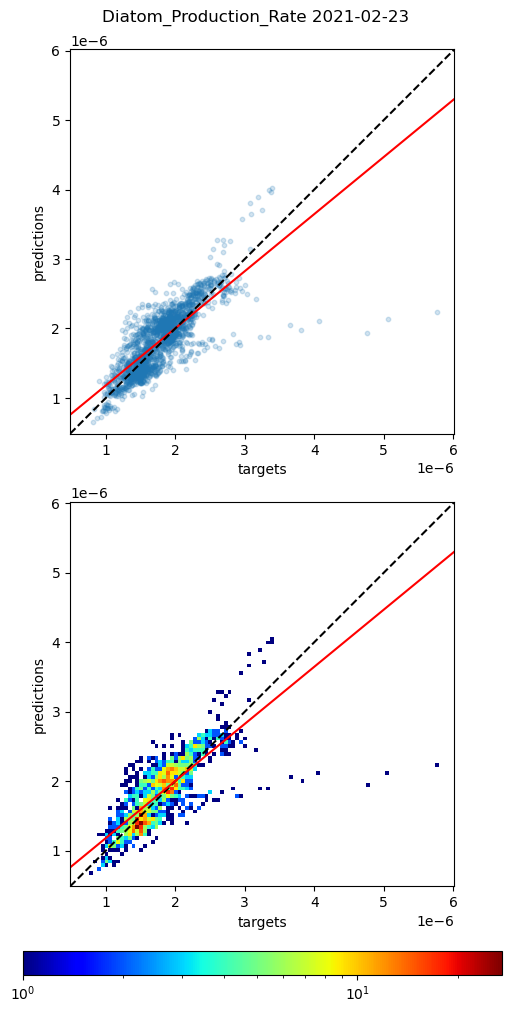

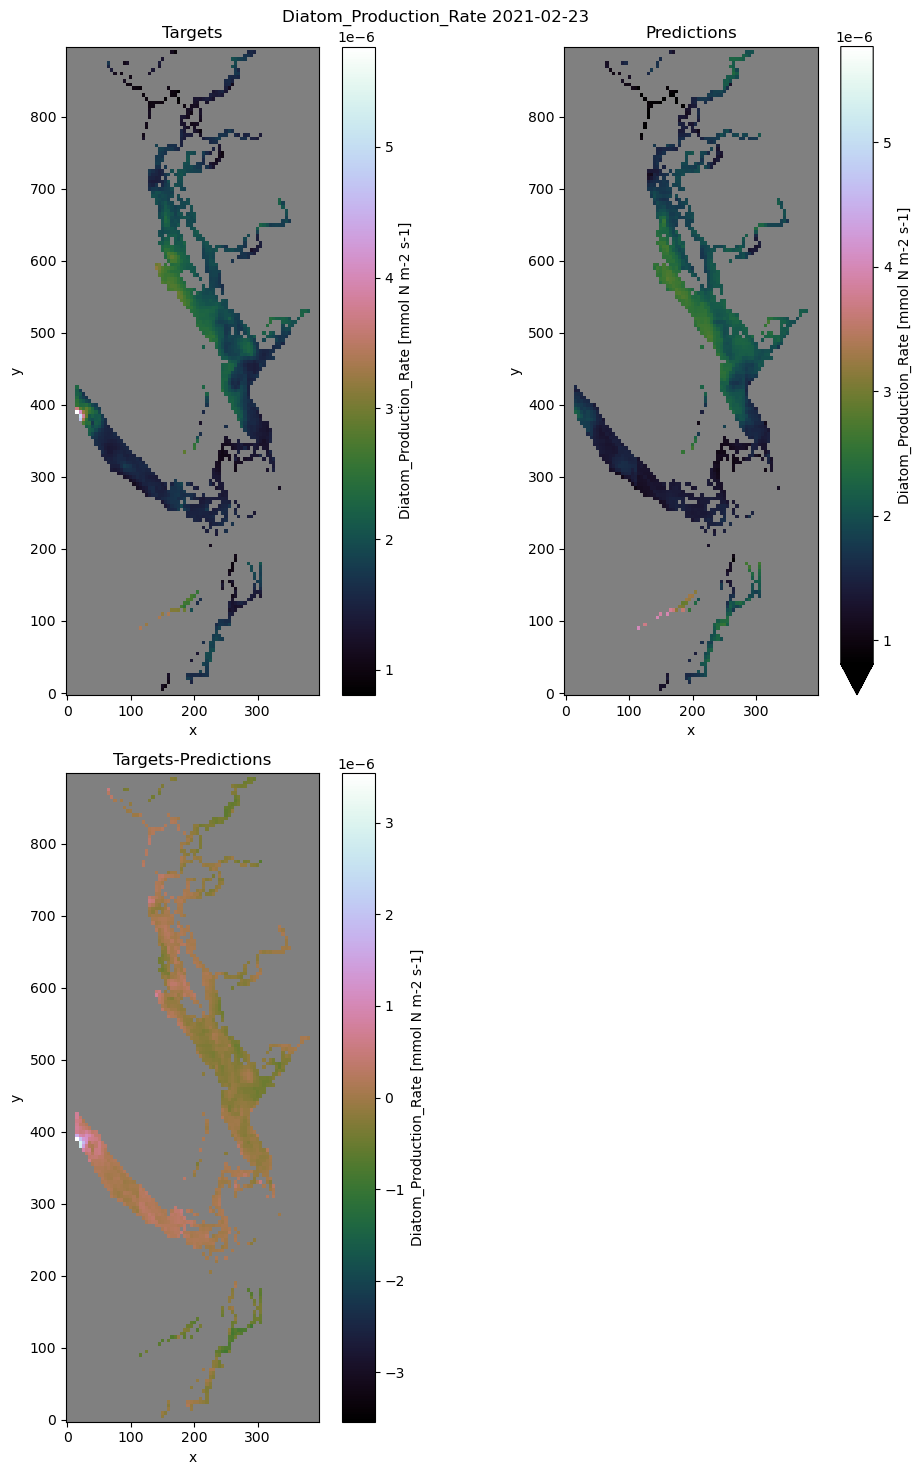

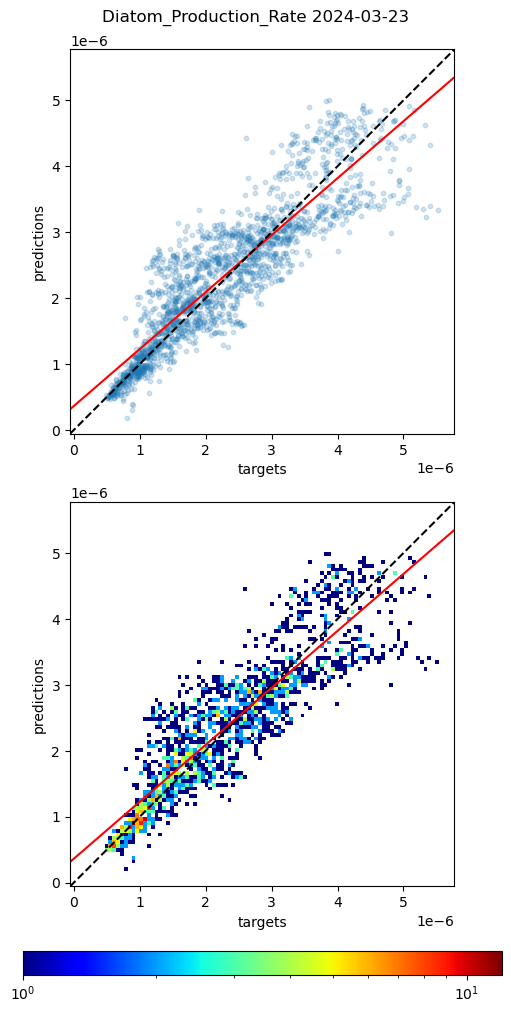

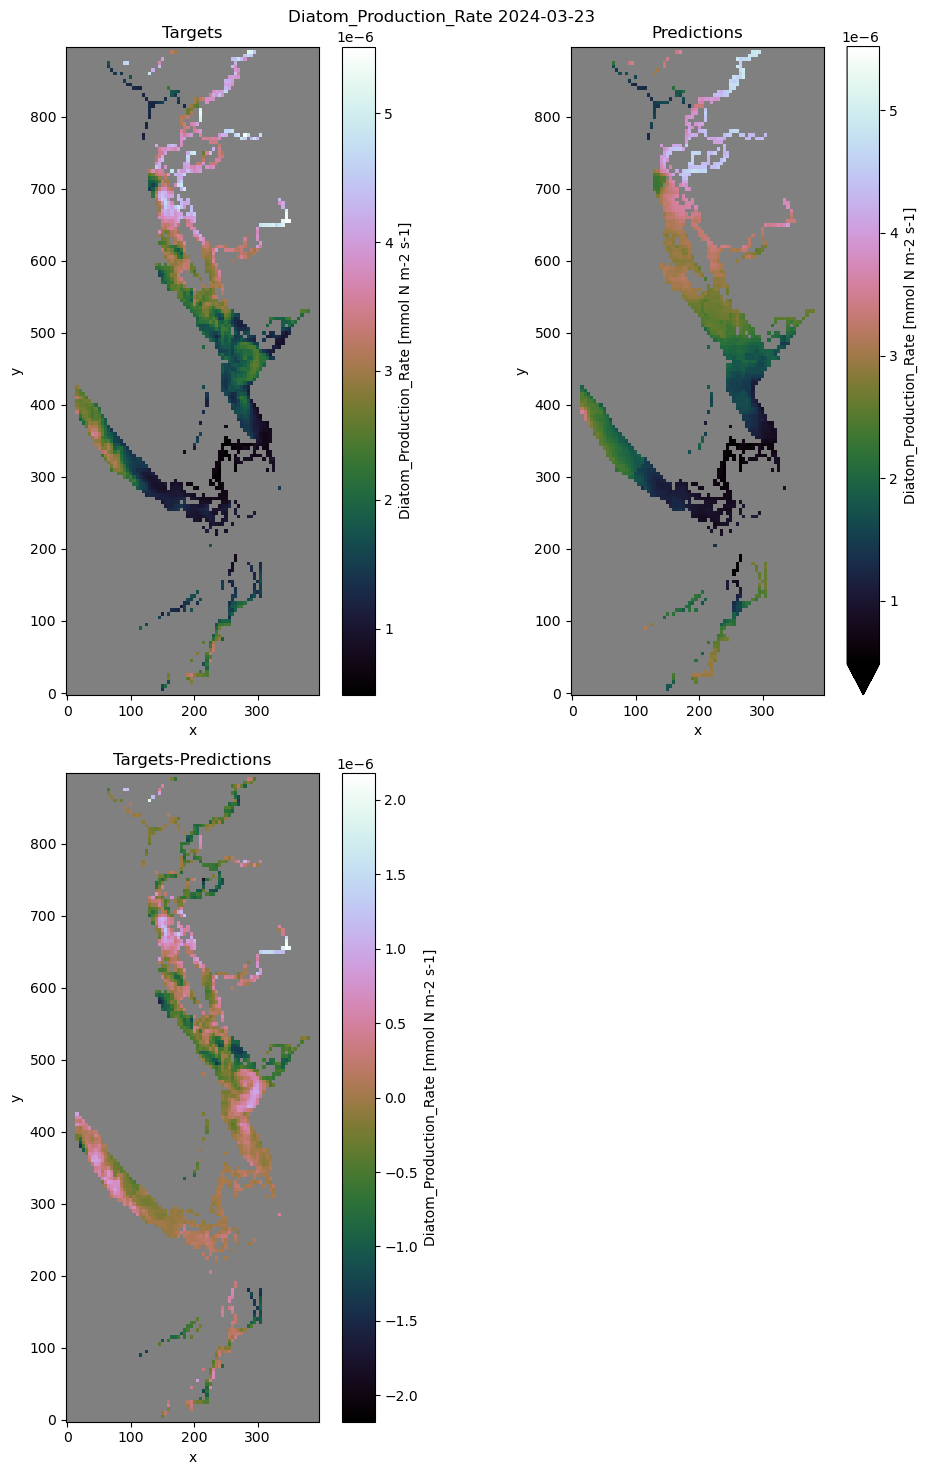

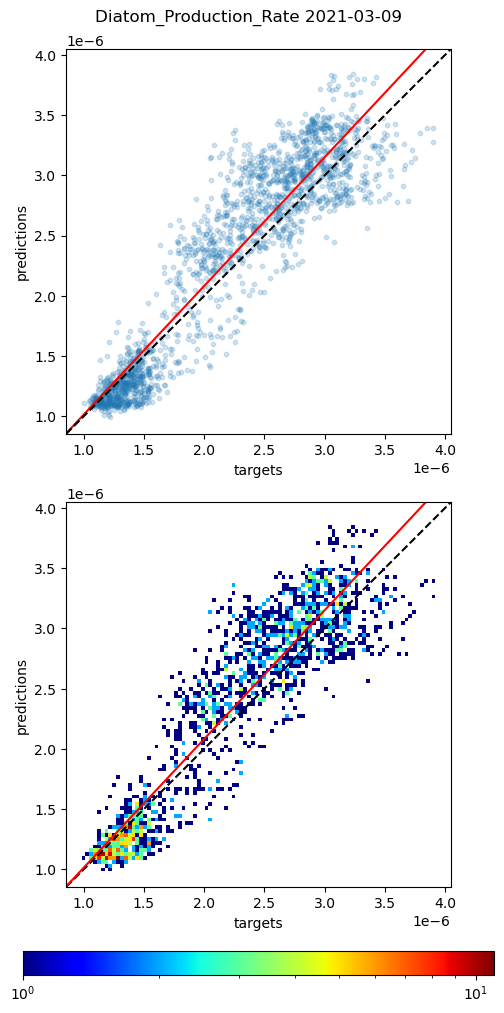

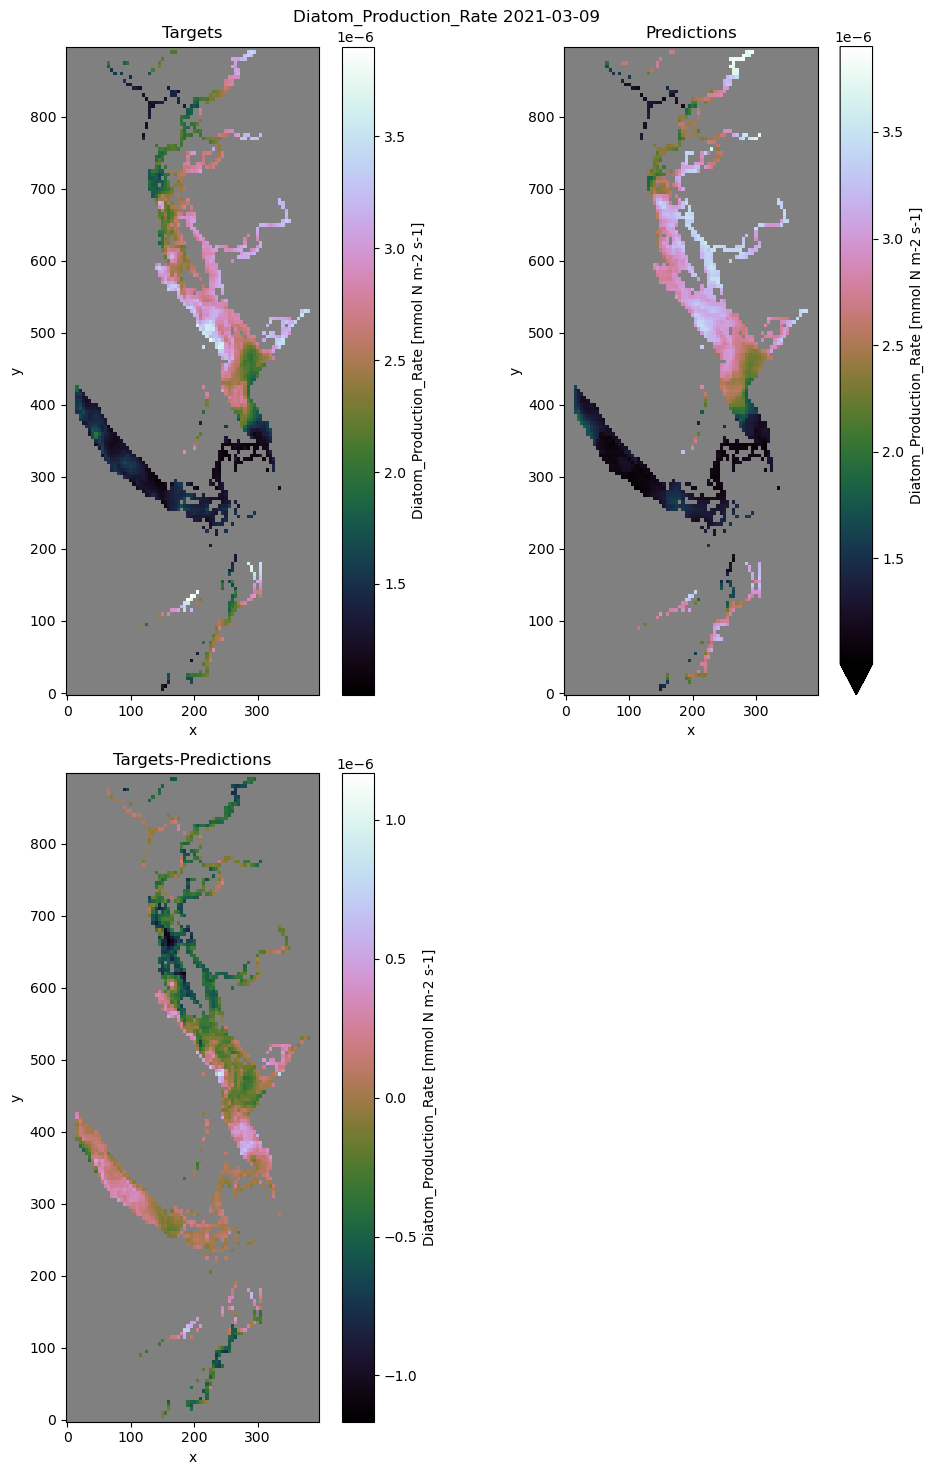

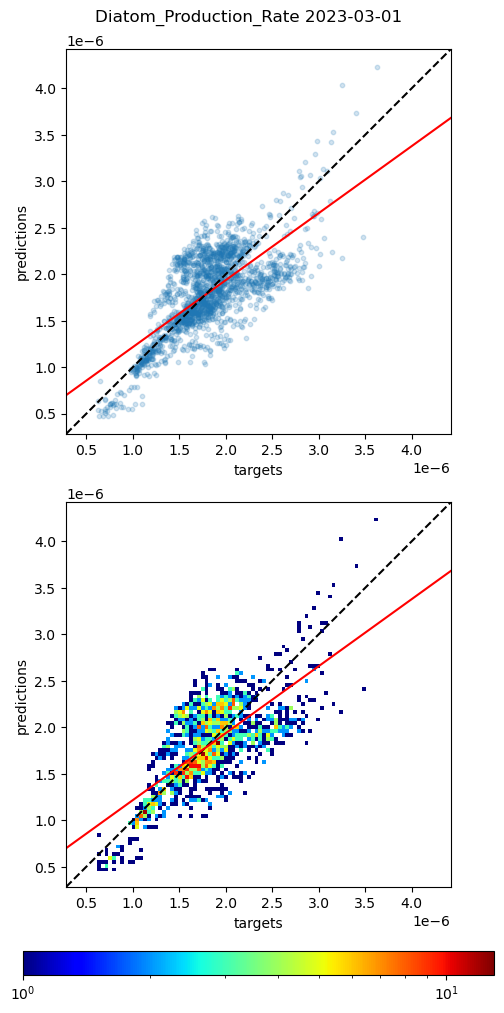

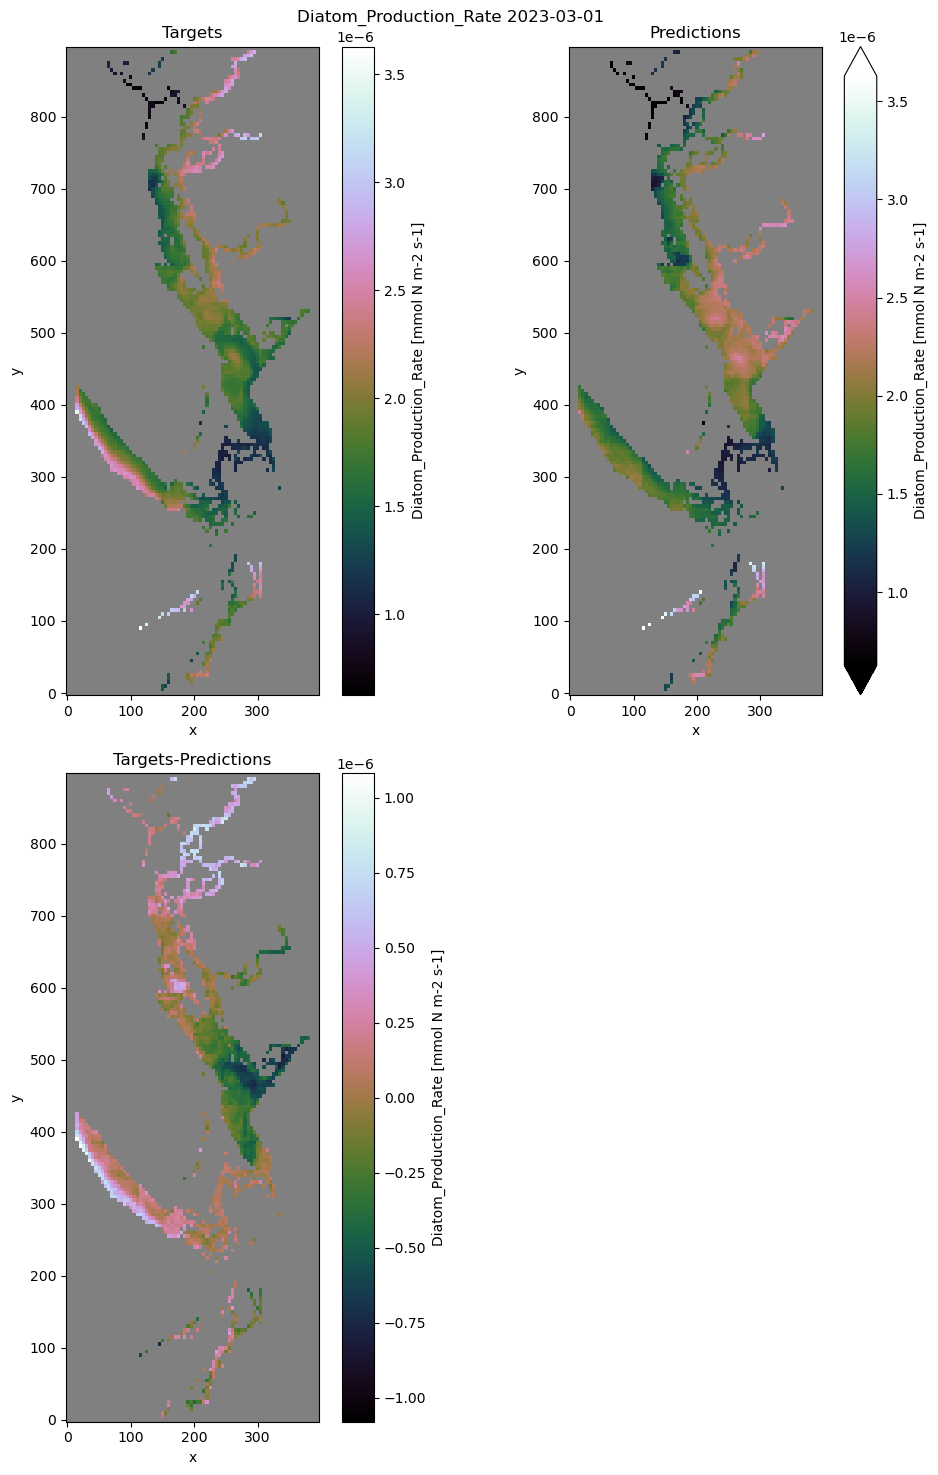

In [27]:
plotting_criteria(dates, r_days, r_years, 'Correlation Coefficients')
plotting_criteria(dates, rms_days, rms_years, 'Root Mean Square Errors')
plotting_criteria(dates, slope_days, slope_years, 'Slopes of the best fitting line')

plotting_mean_values(dates, mean_targets, mean_predictions, units)

# Daily maps
maps = random.sample(sorted(np.arange(0,len(targets_all.time_counter))),10)
for i in maps:

    idx = np.isfinite(np.ravel(targets_all[i]))
    scatter_plot(np.ravel(targets_all[i])[idx], np.ravel(predictions_all[i])[idx], name + ' '+ str(targets_all[i].time_counter.dt.date.values))

    plotting_maps(targets_all[i], predictions_all[i], name, units)
    

## Saving

In [28]:
# path = '/data/ibougoudis/MOAD/files/results/' + name + 'Hist_Grad/'
# os.makedirs(path, exist_ok=True)
# with lzma.open(path + 'regr.xz', 'wb') as f:
#     dill.dump(regr, f)

# file_creation(path, targets_all, 'Targets')
# file_creation(path, predictions_all, 'Predictions')
# file_creation(path, (targets_all-predictions_all), 'Targets - Predictions')
